#### Versions:
* v9: ColorJitter transformation added **[0.896]**
* v10: Changed the dataset to [this one](https://www.kaggle.com/shonenkov/melanoma-merged-external-data-512x512-jpeg) with external data. **[0.894]**
* v11: Switched to [another dataset](https://www.kaggle.com/nroman/melanoma-external-malignant-256/) which I've created by myself. Also switched from StratifiedKFold to GroupKFold **[0.916]**
* v12: Switched to efficientnet-b1 **[0.919]**
* v13: Using meta featues: sex and age **[0.918]**
* v14: anatom_site_general_challenge meta feature added as one-hot encoded matrix **[0.923]**
* v16: Fixed OOF - now it contains only data from original training dataset, without extarnal data. Also switched back to StratifiedKFold. Added DrawHair augmentation. **[0.909]**
* v18: Too many things were changed at the same time. All experiments should have only one small change each, so it would be easy to understand how changes affect the result. Said that I rolled back everything, keeping only OOF fix, to make sure it work.
* v19: Added 'Hair' augmentation. OOF rework posponed untill the best time, since there is some bug in my code for it. **[0.925]**
* v20: Advanced Hair Augmentation technique used. Read more about it here: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/159176 **[0.923]**
* v21: Microscope augmentation added instead of Cutout. Read more here: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/159476 **[0.914]**
* v22: Changed the dataset to [this one](https://www.kaggle.com/cdeotte/jpeg-melanoma-256x256) by Chris Deotte. More info [here](https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/165526) **[0.900]**
* v23: All the same as v22 but effnet-b0 instead of b1 and more epochs per fold.

In [1]:
!pip install efficientnet_pytorch torchtoolbox

     |████████████████████████████████| 55 kB 1.7 MB/s 
     |████████████████████████████████| 869 kB 8.3 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12419 sha256=95ae5ac34f3e474d79a055c10f3d79e33e37fb8a155125b0407844b8337dacad
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for lmdb: filename=lmdb-0.98-cp37-cp37m-linux_x86_64.whl size=273148 sha256=713c3067b25e156d9feb1c0041a5c85d1fd936ece22416adcb996d56ef8c4e5d
  Stored in directory: /root/.cache/pip/wheels/9e/24/96/783d4dddcf63e3f8cc92db8b3af3c70cf6d76398bff77f1d5e
Successfully built efficientnet-pytorch lmdb
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
import torchtoolbox.transform as transforms
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
import pandas as pd
import numpy as np
import gc
import os
import cv2
import time
import datetime
import warnings
import random
import matplotlib.pyplot as plt
import seaborn as sns
from efficientnet_pytorch import EfficientNet
%matplotlib inline

In [3]:
warnings.simplefilter('ignore')
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(47)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
class MelanomaDataset(Dataset):
    def __init__(self, df: pd.DataFrame, imfolder: str, train: bool = True, transforms = None, meta_features = None):
        """
        Class initialization
        Args:
            df (pd.DataFrame): DataFrame with data description
            imfolder (str): folder with images
            train (bool): flag of whether a training dataset is being initialized or testing one
            transforms: image transformation method to be applied
            meta_features (list): list of features with meta information, such as sex and age
            
        """
        self.df = df
        self.imfolder = imfolder
        self.transforms = transforms
        self.train = train
        self.meta_features = meta_features
        
    def __getitem__(self, index):
        im_path = os.path.join(self.imfolder, self.df.iloc[index]['image_name'] + '.jpg')
        x = cv2.imread(im_path)
        meta = np.array(self.df.iloc[index][self.meta_features].values, dtype=np.float32)

        if self.transforms:
            x = self.transforms(x)
            
        if self.train:
            y = self.df.iloc[index]['target']
            return (x, meta), y
        else:
            return (x, meta)
    
    def __len__(self):
        return len(self.df)
    
    
class Net(nn.Module):
    def __init__(self, arch, n_meta_features: int):
        super(Net, self).__init__()
        self.arch = arch
        if 'ResNet' in str(arch.__class__):
            self.arch.fc = nn.Linear(in_features=512, out_features=500, bias=True)
        if 'EfficientNet' in str(arch.__class__):
            self.arch._fc = nn.Linear(in_features=1280, out_features=500, bias=True)
        self.meta = nn.Sequential(nn.Linear(n_meta_features, 500),
                                  nn.BatchNorm1d(500),
                                  nn.ReLU(),
                                  nn.Dropout(p=0.2),
                                  nn.Linear(500, 250),  # FC layer output will have 250 features
                                  nn.BatchNorm1d(250),
                                  nn.ReLU(),
                                  nn.Dropout(p=0.2))
        self.ouput = nn.Linear(500 + 250, 1)
        
    def forward(self, inputs):
        """
        No sigmoid in forward because we are going to use BCEWithLogitsLoss
        Which applies sigmoid for us when calculating a loss
        """
        x, meta = inputs
        cnn_features = self.arch(x)
        meta_features = self.meta(meta)
        features = torch.cat((cnn_features, meta_features), dim=1)
        output = self.ouput(features)
        return output

In [6]:
class AdvancedHairAugmentation:
    """
    Impose an image of a hair to the target image

    Args:
        hairs (int): maximum number of hairs to impose
        hairs_folder (str): path to the folder with hairs images
    """

    def __init__(self, hairs: int = 5, hairs_folder: str = ""):
        self.hairs = hairs
        self.hairs_folder = hairs_folder

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to draw hairs on.

        Returns:
            PIL Image: Image with drawn hairs.
        """
        n_hairs = random.randint(0, self.hairs)
        
        if not n_hairs:
            return img
        
        height, width, _ = img.shape  # target image width and height
        hair_images = [im for im in os.listdir(self.hairs_folder) if 'png' in im]
        
        for _ in range(n_hairs):
            hair = cv2.imread(os.path.join(self.hairs_folder, random.choice(hair_images)))
            hair = cv2.flip(hair, random.choice([-1, 0, 1]))
            hair = cv2.rotate(hair, random.choice([0, 1, 2]))

            h_height, h_width, _ = hair.shape  # hair image width and height
            roi_ho = random.randint(0, img.shape[0] - hair.shape[0])
            roi_wo = random.randint(0, img.shape[1] - hair.shape[1])
            roi = img[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width]

            # Creating a mask and inverse mask
            img2gray = cv2.cvtColor(hair, cv2.COLOR_BGR2GRAY)
            ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
            mask_inv = cv2.bitwise_not(mask)

            # Now black-out the area of hair in ROI
            img_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)

            # Take only region of hair from hair image.
            hair_fg = cv2.bitwise_and(hair, hair, mask=mask)

            # Put hair in ROI and modify the target image
            dst = cv2.add(img_bg, hair_fg)

            img[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width] = dst
                
        return img

    def __repr__(self):
        return f'{self.__class__.__name__}(hairs={self.hairs}, hairs_folder="{self.hairs_folder}")'

In [7]:
class DrawHair:
    """
    Draw a random number of pseudo hairs

    Args:
        hairs (int): maximum number of hairs to draw
        width (tuple): possible width of the hair in pixels
    """

    def __init__(self, hairs:int = 4, width:tuple = (1, 2)):
        self.hairs = hairs
        self.width = width

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to draw hairs on.

        Returns:
            PIL Image: Image with drawn hairs.
        """
        if not self.hairs:
            return img
        
        width, height, _ = img.shape
        
        for _ in range(random.randint(0, self.hairs)):
            # The origin point of the line will always be at the top half of the image
            origin = (random.randint(0, width), random.randint(0, height // 2))
            # The end of the line 
            end = (random.randint(0, width), random.randint(0, height))
            color = (0, 0, 0)  # color of the hair. Black.
            cv2.line(img, origin, end, color, random.randint(self.width[0], self.width[1]))
        
        return img

    def __repr__(self):
        return f'{self.__class__.__name__}(hairs={self.hairs}, width={self.width})'

In [8]:
class Microscope:
    """
    Cutting out the edges around the center circle of the image
    Imitating a picture, taken through the microscope

    Args:
        p (float): probability of applying an augmentation
    """

    def __init__(self, p: float = 0.5):
        self.p = p

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to apply transformation to.

        Returns:
            PIL Image: Image with transformation.
        """
        if random.random() < self.p:
            circle = cv2.circle((np.ones(img.shape) * 255).astype(np.uint8), # image placeholder
                        (img.shape[0]//2, img.shape[1]//2), # center point of circle
                        random.randint(img.shape[0]//2 - 3, img.shape[0]//2 + 15), # radius
                        (0, 0, 0), # color
                        -1)

            mask = circle - 255
            img = np.multiply(img, mask)
        
        return img

    def __repr__(self):
        return f'{self.__class__.__name__}(p={self.p})'

In [9]:
train_transform = transforms.Compose([
    AdvancedHairAugmentation(hairs_folder='/kaggle/input/melanoma-hairs'),
    transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    Microscope(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

In [10]:
arch = EfficientNet.from_pretrained('efficientnet-b0')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/checkpoints/efficientnet-b0-355c32eb.pth



Loaded pretrained weights for efficientnet-b0


In [11]:
train_df = pd.read_csv('/kaggle/input/jpeg-melanoma-256x256/train.csv')
test_df = pd.read_csv('/kaggle/input/jpeg-melanoma-256x256/test.csv')

In [12]:
# Using triple stratified KFolds
tmp = pd.read_csv('/kaggle/input/melanoma-256x256/train.csv')
train_df['fold'] = tmp['tfrecord']
del tmp
gc.collect();

In [13]:
# One-hot encoding of anatom_site_general_challenge feature
concat = pd.concat([train_df['anatom_site_general_challenge'], test_df['anatom_site_general_challenge']], ignore_index=True)
dummies = pd.get_dummies(concat, dummy_na=True, dtype=np.uint8, prefix='site')
train_df = pd.concat([train_df, dummies.iloc[:train_df.shape[0]]], axis=1)
test_df = pd.concat([test_df, dummies.iloc[train_df.shape[0]:].reset_index(drop=True)], axis=1)

# Sex features
train_df['sex'] = train_df['sex'].map({'male': 1, 'female': 0})
test_df['sex'] = test_df['sex'].map({'male': 1, 'female': 0})
train_df['sex'] = train_df['sex'].fillna(-1)
test_df['sex'] = test_df['sex'].fillna(-1)

# Age features
train_df['age_approx'] /= train_df['age_approx'].max()
test_df['age_approx'] /= test_df['age_approx'].max()
train_df['age_approx'] = train_df['age_approx'].fillna(0)
test_df['age_approx'] = test_df['age_approx'].fillna(0)

train_df['patient_id'] = train_df['patient_id'].fillna(0)

In [14]:
meta_features = ['sex', 'age_approx'] + [col for col in train_df.columns if 'site_' in col]
meta_features.remove('anatom_site_general_challenge')

In [15]:
test = MelanomaDataset(df=test_df,
                       imfolder='/kaggle/input/jpeg-melanoma-256x256/test/', 
                       train=False,
                       transforms=train_transform,  # For TTA
                       meta_features=meta_features)

In [16]:
epochs = 15  # Number of epochs to run
es_patience = 3  # Early Stopping patience - for how many epochs with no improvements to wait
TTA = 3 # Test Time Augmentation rounds

oof = np.zeros((len(train_df), 1))  # Out Of Fold predictions
preds = torch.zeros((len(test), 1), dtype=torch.float32, device=device)  # Predictions for test test

skf = KFold(n_splits=5, shuffle=True, random_state=47)
for fold,(idxT, idxV) in enumerate(skf.split(np.arange(15)), 1):
    print('=' * 20, 'Fold', fold, '=' * 20)
    
    train_idx = train_df.loc[train_df['fold'].isin(idxT)].index
    val_idx = train_df.loc[train_df['fold'].isin(idxV)].index
    
    
    model_path = f'model_{fold}.pth'  # Path and filename to save model to
    best_val = 0  # Best validation score within this fold
    patience = es_patience  # Current patience counter
    arch = EfficientNet.from_pretrained('efficientnet-b0')
    model = Net(arch=arch, n_meta_features=len(meta_features))  # New model for each fold
    model = model.to(device)
    
    
    optim = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = ReduceLROnPlateau(optimizer=optim, mode='max', patience=1, verbose=True, factor=0.2)
    criterion = nn.BCEWithLogitsLoss()
    
    train = MelanomaDataset(df=train_df.iloc[train_idx].reset_index(drop=True), 
                            imfolder='/kaggle/input/jpeg-melanoma-256x256/train/', 
                            train=True, 
                            transforms=train_transform,
                            meta_features=meta_features)
    val = MelanomaDataset(df=train_df.iloc[val_idx].reset_index(drop=True), 
                            imfolder='/kaggle/input/jpeg-melanoma-256x256/train/', 
                            train=True, 
                            transforms=test_transform,
                            meta_features=meta_features)
    
    train_loader = DataLoader(dataset=train, batch_size=64, shuffle=True, num_workers=2)
    val_loader = DataLoader(dataset=val, batch_size=16, shuffle=False, num_workers=2)
    test_loader = DataLoader(dataset=test, batch_size=16, shuffle=False, num_workers=2)
    
    for epoch in range(epochs):
        start_time = time.time()
        correct = 0
        epoch_loss = 0
        model.train()
        
        for x, y in train_loader:
            x[0] = torch.tensor(x[0], device=device, dtype=torch.float32)
            x[1] = torch.tensor(x[1], device=device, dtype=torch.float32)
            y = torch.tensor(y, device=device, dtype=torch.float32)
            optim.zero_grad()
            z = model(x)
            loss = criterion(z, y.unsqueeze(1))
            loss.backward()
            optim.step()
            pred = torch.round(torch.sigmoid(z))  # round off sigmoid to obtain predictions
            correct += (pred.cpu() == y.cpu().unsqueeze(1)).sum().item()  # tracking number of correctly predicted samples
            epoch_loss += loss.item()
        train_acc = correct / len(train_idx)
        
        model.eval()  # switch model to the evaluation mode
        val_preds = torch.zeros((len(val_idx), 1), dtype=torch.float32, device=device)
        with torch.no_grad():  # Do not calculate gradient since we are only predicting
            # Predicting on validation set
            for j, (x_val, y_val) in enumerate(val_loader):
                x_val[0] = torch.tensor(x_val[0], device=device, dtype=torch.float32)
                x_val[1] = torch.tensor(x_val[1], device=device, dtype=torch.float32)
                y_val = torch.tensor(y_val, device=device, dtype=torch.float32)
                z_val = model(x_val)
                val_pred = torch.sigmoid(z_val)
                val_preds[j*x_val[0].shape[0]:j*x_val[0].shape[0] + x_val[0].shape[0]] = val_pred
            val_acc = accuracy_score(train_df.iloc[val_idx]['target'].values, torch.round(val_preds.cpu()))
            val_roc = roc_auc_score(train_df.iloc[val_idx]['target'].values, val_preds.cpu())
            
            print('Epoch {:03}: | Loss: {:.3f} | Train acc: {:.3f} | Val acc: {:.3f} | Val roc_auc: {:.3f} | Training time: {}'.format(
            epoch + 1, 
            epoch_loss, 
            train_acc, 
            val_acc, 
            val_roc, 
            str(datetime.timedelta(seconds=time.time() - start_time))[:7]))
            
            scheduler.step(val_roc)
                
            if val_roc >= best_val:
                best_val = val_roc
                patience = es_patience  # Resetting patience since we have new best validation accuracy
                torch.save(model, model_path)  # Saving current best model
            else:
                patience -= 1
                if patience == 0:
                    print('Early stopping. Best Val roc_auc: {:.3f}'.format(best_val))
                    break
                
    model = torch.load(model_path)  # Loading best model of this fold
    model.eval()  # switch model to the evaluation mode
    val_preds = torch.zeros((len(val_idx), 1), dtype=torch.float32, device=device)
    with torch.no_grad():
        # Predicting on validation set once again to obtain data for OOF
        for j, (x_val, y_val) in enumerate(val_loader):
            x_val[0] = torch.tensor(x_val[0], device=device, dtype=torch.float32)
            x_val[1] = torch.tensor(x_val[1], device=device, dtype=torch.float32)
            y_val = torch.tensor(y_val, device=device, dtype=torch.float32)
            z_val = model(x_val)
            val_pred = torch.sigmoid(z_val)
            val_preds[j*x_val[0].shape[0]:j*x_val[0].shape[0] + x_val[0].shape[0]] = val_pred
        oof[val_idx] = val_preds.cpu().numpy()
        
        # Predicting on test set
        for _ in range(TTA):
            for i, x_test in enumerate(test_loader):
                x_test[0] = torch.tensor(x_test[0], device=device, dtype=torch.float32)
                x_test[1] = torch.tensor(x_test[1], device=device, dtype=torch.float32)
                z_test = model(x_test)
                z_test = torch.sigmoid(z_test)
                preds[i*x_test[0].shape[0]:i*x_test[0].shape[0] + x_test[0].shape[0]] += z_test
        preds /= TTA
        
    del train, val, train_loader, val_loader, x, y, x_val, y_val
    gc.collect()
    
preds /= skf.n_splits

==================== Fold 1 ====================
Loaded pretrained weights for efficientnet-b0
Epoch 001: | Loss: 35.248 | Train acc: 0.980 | Val acc: 0.982 | Val roc_auc: 0.834 | Training time: 0:05:23
Epoch 002: | Loss: 31.064 | Train acc: 0.982 | Val acc: 0.982 | Val roc_auc: 0.751 | Training time: 0:05:03
Epoch 003: | Loss: 30.755 | Train acc: 0.982 | Val acc: 0.982 | Val roc_auc: 0.852 | Training time: 0:05:02
Epoch 004: | Loss: 29.762 | Train acc: 0.982 | Val acc: 0.981 | Val roc_auc: 0.859 | Training time: 0:05:01
Epoch 005: | Loss: 28.882 | Train acc: 0.982 | Val acc: 0.982 | Val roc_auc: 0.819 | Training time: 0:05:01
Epoch 006: | Loss: 29.112 | Train acc: 0.982 | Val acc: 0.982 | Val roc_auc: 0.859 | Training time: 0:05:02
Epoch 007: | Loss: 28.447 | Train acc: 0.982 | Val acc: 0.980 | Val roc_auc: 0.858 | Training time: 0:05:00
Epoch 008: | Loss: 28.328 | Train acc: 0.982 | Val acc: 0.982 | Val roc_auc: 0.871 | Training time: 0:04:59
Epoch 009: | Loss: 27.218 | Train acc: 0.

In [17]:
print('OOF: {:.3f}'.format(roc_auc_score(train_df['target'], oof)))

OOF: 0.883


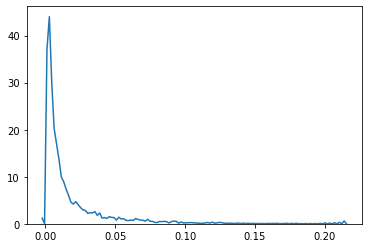

In [18]:
sns.kdeplot(pd.Series(preds.cpu().numpy().reshape(-1,)));

In [19]:
# Saving OOF predictions so stacking would be easier
pd.Series(oof.reshape(-1,)).to_csv('oof.csv', index=False)

In [20]:
sub = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/sample_submission.csv')
sub['target'] = preds.cpu().numpy().reshape(-1,)
sub.to_csv('submission.csv', index=False)